# Rough Heston Affine Volatility Models

**Simplified Introduction to Rough Volatility**

Based on *"Rough Volatility Workshop - QM2024_3_Affine_models"* by **F. Bourgey (2024)**

**Reference:** [GitHub - RoughVolatilityWorkshop](https://github.com/fbourgey/RoughVolatilityWorkshop/blob/main/QM2024_3_Affine_models.ipynb)

---

## Overview

Rough volatility models capture the **fractal nature** of market volatility observed in empirical data. Unlike classical stochastic volatility models with smooth paths, rough volatility exhibits:

- **Roughness:** Hurst parameter H < 0.5 (vs. Brownian H = 0.5)
- **Power-law behavior:** Long-range dependence in volatility increments  
- **Realistic skew:** Matches implied volatility surfaces better than classical models

In [1]:
# Setup and Imports
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent.parent / "python"))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import gamma as scipy_gamma

# Import our rough Heston implementation
from rough_heston import (
    RoughHestonParams,
    RoughHestonCharFunc,

    rough_heston_kernel,
    normalized_leverage_contract,
    atm_skew,
    skew_stickiness_ratio,
    SPX_CALIBRATED_PARAMS
)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Rough Heston module loaded successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

✅ Rough Heston module loaded successfully!
NumPy version: 1.26.4
Pandas version: 2.1.4


## 1. Mittag-Leffler Functions

The **generalized Mittag-Leffler function** is the key ingredient:

$$E_{\alpha,\beta}(z) = \sum_{k=0}^{\infty} \frac{z^k}{\Gamma(\alpha k + \beta)}$$

This generalizes the exponential function:
- $E_{1,1}(z) = e^z$ (classical exponential)
- For $0 < \alpha < 1$, exhibits **power-law decay** instead of exponential

**Why it matters:** Captures the rough behavior of volatility with fractional calculus.

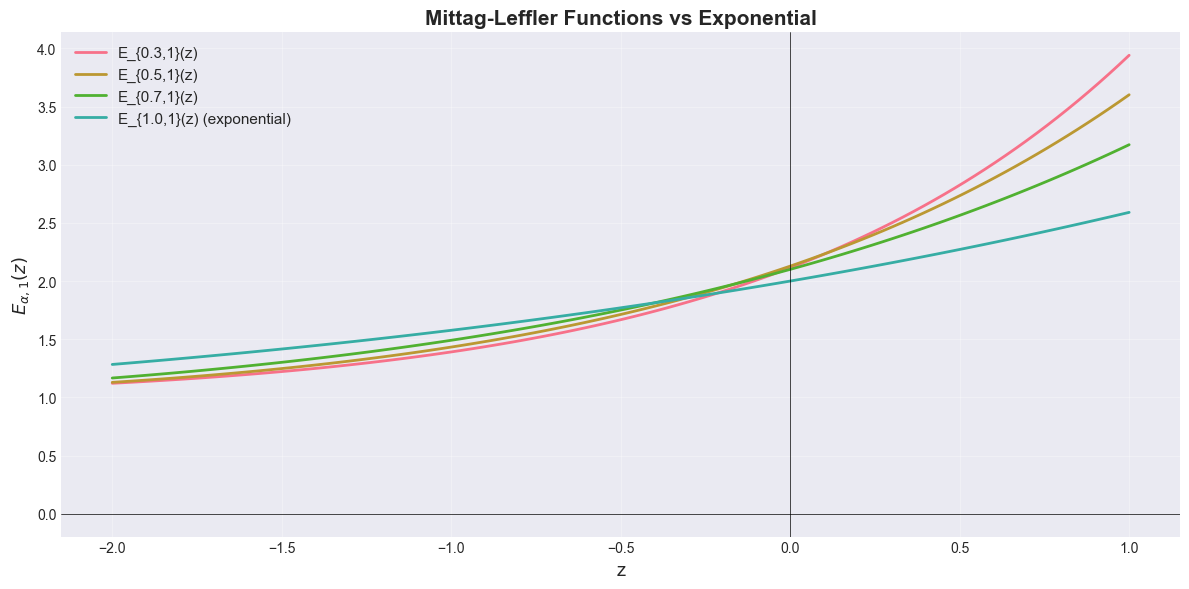

📊 Notice how α < 1 gives slower decay than exponential (α = 1)


In [2]:
# Visualize Mittag-Leffler vs Exponential
from rough_heston import mittag_leffler_two

z_vals = np.linspace(-2, 1, 100)
alpha_vals = [0.3, 0.5, 0.7, 1.0]

plt.figure(figsize=(12, 6))

for alpha in alpha_vals:
    ml_vals = [mittag_leffler_two(z, alpha, 1.0) for z in z_vals]
    label = f'E_{{{alpha:.1f},1}}(z)' + (' (exponential)' if alpha == 1.0 else '')
    plt.plot(z_vals, ml_vals, linewidth=2, label=label)

plt.xlabel('z', fontsize=13)
plt.ylabel('$E_{α,1}(z)$', fontsize=13)
plt.title('Mittag-Leffler Functions vs Exponential', fontsize=15, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linewidth=0.5)
plt.axvline(x=0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

print("📊 Notice how α < 1 gives slower decay than exponential (α = 1)")

## 2. Rough Heston Model Setup

### Parameters

- **H** (Hurst): Roughness parameter, $0 < H < 0.5$ for rough regime
- **η** (nu): Volatility of volatility
- **ρ** (rho): Correlation between returns and volatility (typically negative for equity)
- **λ** (lambda): Mean reversion speed
- **θ** (theta): Long-term variance level
- **V₀** (v0): Initial variance

### Kernel

The rough Heston kernel combines power-law decay with mean reversion:

$$\kappa(\tau) = \eta \tau^{\alpha-1} E_{\alpha,\alpha}(-\lambda \tau^\alpha)$$

where $\alpha = H + 0.5$ is the fractional order.

Rough Heston Parameters (SPX Calibrated):
  Hurst (H):           0.0474  (roughness)
  Vol-of-Vol (η):      0.2910  (volatility intensity)
  Correlation (ρ):     -0.6710  (leverage effect)
  Mean Reversion (λ):  0.0000  (decay speed)
  Long-term Var (θ):   0.0400  (equilibrium level)
  Initial Var (V₀):    0.0400  (current level)

Derived Quantities:
  Alpha (α = H + 0.5): 0.5474
  Lambda' (λ - ρη):    0.1953


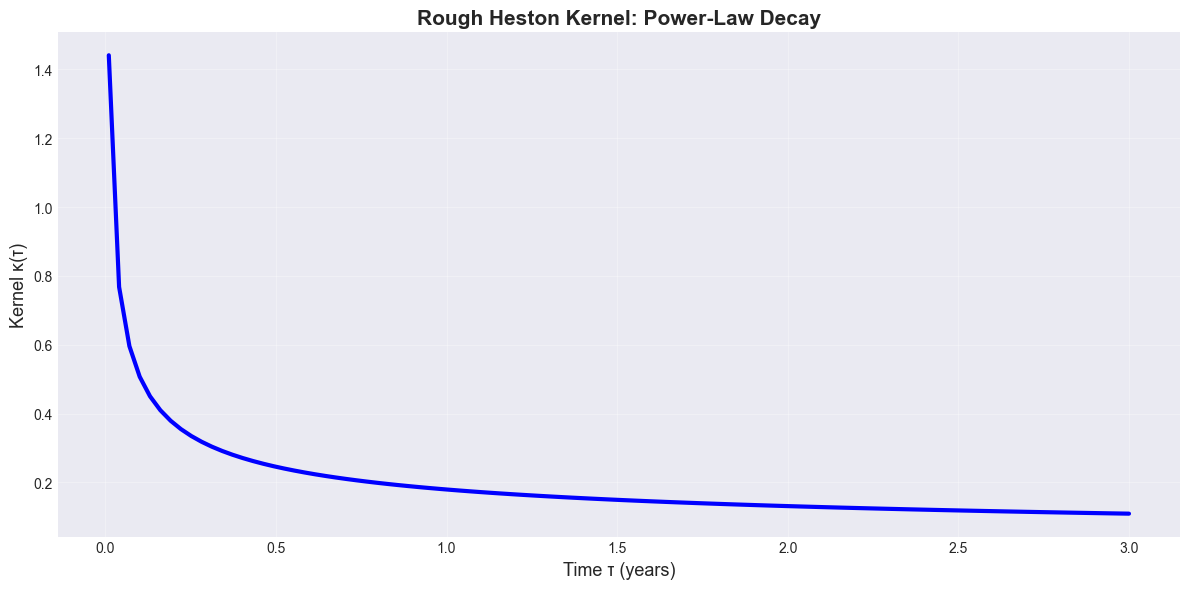


📈 The kernel shows slow power-law decay characteristic of rough volatility


In [3]:
# Create rough Heston parameters (use SPX calibrated values)
params = SPX_CALIBRATED_PARAMS

print("Rough Heston Parameters (SPX Calibrated):")
print("=" * 60)
print(f"  Hurst (H):           {params.H:.4f}  (roughness)")
print(f"  Vol-of-Vol (η):      {params.nu:.4f}  (volatility intensity)")
print(f"  Correlation (ρ):     {params.rho:.4f}  (leverage effect)")
print(f"  Mean Reversion (λ):  {params.lambda_:.4f}  (decay speed)")
print(f"  Long-term Var (θ):   {params.theta:.4f}  (equilibrium level)")
print(f"  Initial Var (V₀):    {params.v0:.4f}  (current level)")
print()
print(f"Derived Quantities:")
print(f"  Alpha (α = H + 0.5): {params.alpha:.4f}")
print(f"  Lambda' (λ - ρη):    {params.lambda_prime:.4f}")

# Visualize kernel
tau_range = np.linspace(0.01, 3.0, 100)
kernel_vals = [rough_heston_kernel(t, params) for t in tau_range]

plt.figure(figsize=(12, 6))
plt.plot(tau_range, kernel_vals, linewidth=3, color='blue')
plt.xlabel('Time τ (years)', fontsize=13)
plt.ylabel('Kernel κ(τ)', fontsize=13)
plt.title('Rough Heston Kernel: Power-Law Decay', fontsize=15, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n📈 The kernel shows slow power-law decay characteristic of rough volatility")

## 3. Leverage Swaps

The **normalized leverage contract** measures realized correlation scaled by variance:

$$L_t(T) = \frac{1}{M_t(T)} \int_t^T \langle dS_s/S_s, d\xi_s(T) \rangle$$

For flat forward variance curve:

$$L_t(T) = \frac{\rho \eta}{\lambda'} \left[1 - E_{\alpha,2}(-\lambda' \tau^\alpha)\right]$$

**Interpretation:** How much does volatility increase when the stock drops?

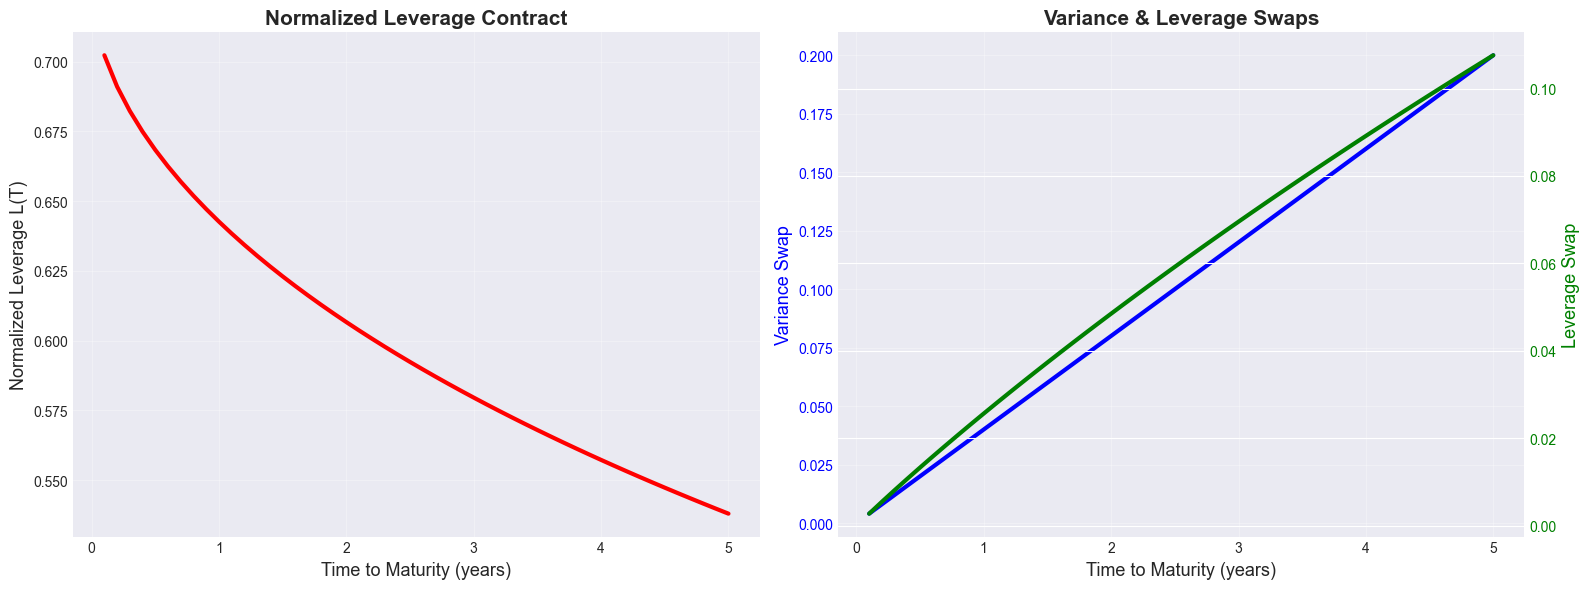


Leverage Swap Values:
 Expiry (Y) Norm Leverage Var Swap Lev Swap
        0.1      0.702267 0.004000 0.002809
        0.6      0.662407 0.024000 0.015898
        1.1      0.638357 0.044000 0.028088
        1.6      0.619535 0.064000 0.039650
        2.1      0.603643 0.084000 0.050706
        2.6      0.589702 0.104000 0.061329
        3.1      0.577182 0.124000 0.071571
        3.6      0.565759 0.144000 0.081469
        4.1      0.555218 0.164000 0.091056
        4.6      0.545405 0.184000 0.100355


In [4]:
# Calculate normalized leverage for different expiries
expiries = np.linspace(0.1, 5.0, 50)
norm_leverage = [normalized_leverage_contract(t, params) for t in expiries]

# Create characteristic function and calculate swaps
char_func = RoughHestonCharFunc(params)
var_swaps = [char_func.variance_swap(t) for t in expiries]
lev_swaps = [char_func.leverage_swap(t) for t in expiries]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Normalized leverage
axes[0].plot(expiries, norm_leverage, linewidth=3, color='red')
axes[0].set_xlabel('Time to Maturity (years)', fontsize=13)
axes[0].set_ylabel('Normalized Leverage L(T)', fontsize=13)
axes[0].set_title('Normalized Leverage Contract', fontsize=15, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Variance and leverage swaps
ax2 = axes[1]
ax2.plot(expiries, var_swaps, linewidth=3, color='blue', label='Variance Swap')
ax2.set_xlabel('Time to Maturity (years)', fontsize=13)
ax2.set_ylabel('Variance Swap', fontsize=13, color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.grid(True, alpha=0.3)

ax2_twin = ax2.twinx()
ax2_twin.plot(expiries, lev_swaps, linewidth=3, color='green', label='Leverage Swap')
ax2_twin.set_ylabel('Leverage Swap', fontsize=13, color='green')
ax2_twin.tick_params(axis='y', labelcolor='green')

axes[1].set_title('Variance & Leverage Swaps', fontsize=15, fontweight='bold')

plt.tight_layout()
plt.show()

# Display values
df_swaps = pd.DataFrame({
    'Expiry (Y)': expiries[::5],
    'Norm Leverage': [f"{x:.6f}" for x in norm_leverage[::5]],
    'Var Swap': [f"{x:.6f}" for x in var_swaps[::5]],
    'Lev Swap': [f"{x:.6f}" for x in lev_swaps[::5]]
})

print("\nLeverage Swap Values:")
print(df_swaps.to_string(index=False))

## 4. ATM Skew and Skew-Stickiness Ratio

### ATM Skew

The **at-the-money skew** is the first derivative of implied volatility:

$$\frac{\partial \sigma}{\partial k}\bigg|_{k=0} \approx -\frac{\rho \eta}{2\sqrt{\theta \tau}}$$

- Negative skew (ρ < 0) means OTM puts more expensive than OTM calls
- Steeper for short maturities (1/√τ term)

### Skew-Stickiness Ratio (SSR)

$$\text{SSR} \approx \frac{1 + \alpha}{2}$$

- **SSR = 0:** Sticky strike (skew in strike space)
- **SSR = 0.5:** Sticky moneyness (skew in log-moneyness space)  
- **SSR = 1:** Sticky delta (skew in delta space)

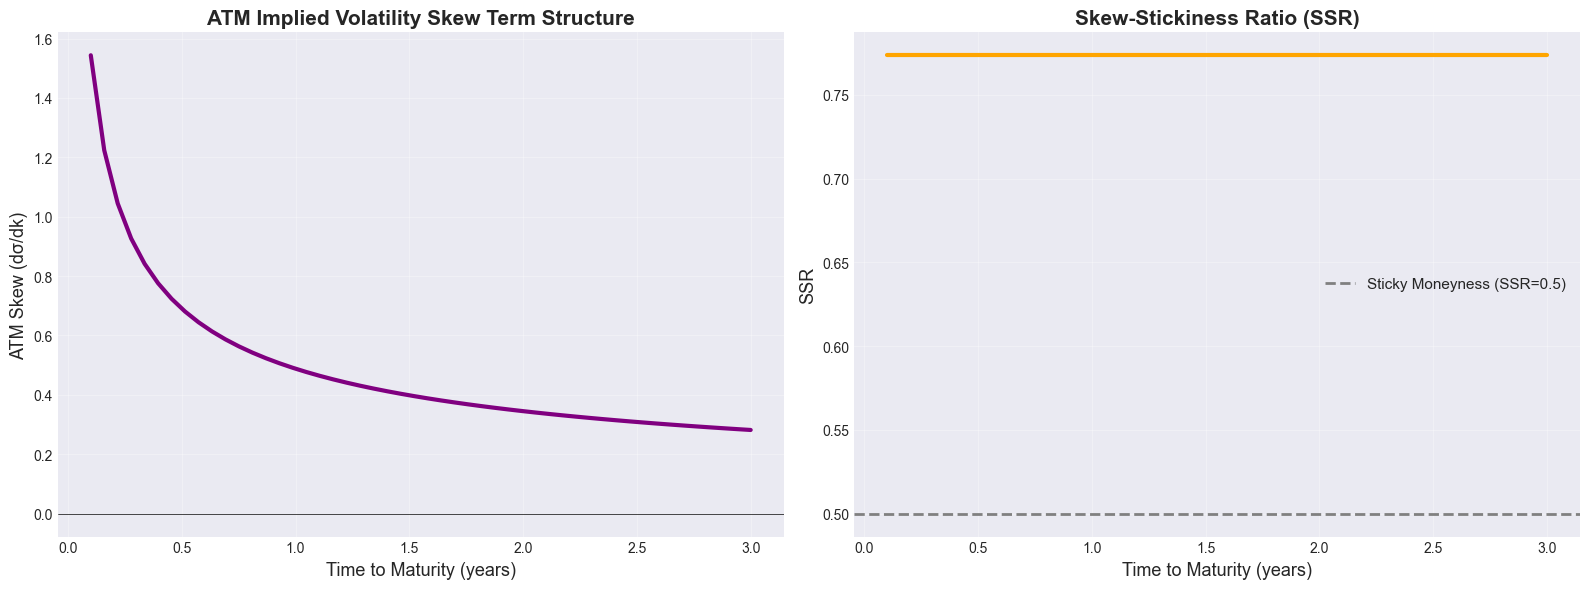


📊 Market Characteristics:
   Average SSR: 0.7737
   Interpretation: Sticky delta regime

   ATM Skew at 1Y: 0.488152
   Negative → OTM puts more expensive than OTM calls


In [5]:
# Calculate ATM skew term structure
expiries_skew = np.linspace(0.1, 3.0, 50)
skews = [atm_skew(char_func, t) for t in expiries_skew]
ssrs = [skew_stickiness_ratio(char_func, t) for t in expiries_skew]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ATM Skew
axes[0].plot(expiries_skew, skews, linewidth=3, color='purple')
axes[0].set_xlabel('Time to Maturity (years)', fontsize=13)
axes[0].set_ylabel('ATM Skew (dσ/dk)', fontsize=13)
axes[0].set_title('ATM Implied Volatility Skew Term Structure', fontsize=15, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0, color='black', linewidth=0.5)

# SSR
axes[1].plot(expiries_skew, ssrs, linewidth=3, color='orange')
axes[1].axhline(y=0.5, color='gray', linestyle='--', linewidth=2, label='Sticky Moneyness (SSR=0.5)')
axes[1].set_xlabel('Time to Maturity (years)', fontsize=13)
axes[1].set_ylabel('SSR', fontsize=13)
axes[1].set_title('Skew-Stickiness Ratio (SSR)', fontsize=15, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
avg_ssr = np.mean(ssrs)
print(f"\n📊 Market Characteristics:")
print(f"   Average SSR: {avg_ssr:.4f}")
print(f"   Interpretation: ", end="")
if abs(avg_ssr - 0.5) < 0.05:
    print("Close to sticky moneyness")
elif avg_ssr < 0.3:
    print("Sticky strike regime")
elif avg_ssr > 0.7:
    print("Sticky delta regime")
else:
    print("Mixed regime")

print(f"\n   ATM Skew at 1Y: {atm_skew(char_func, 1.0):.6f}")
print(f"   Negative → OTM puts more expensive than OTM calls")

## 5. Comparison: Different Hurst Parameters

Explore how roughness affects model behavior by varying H.

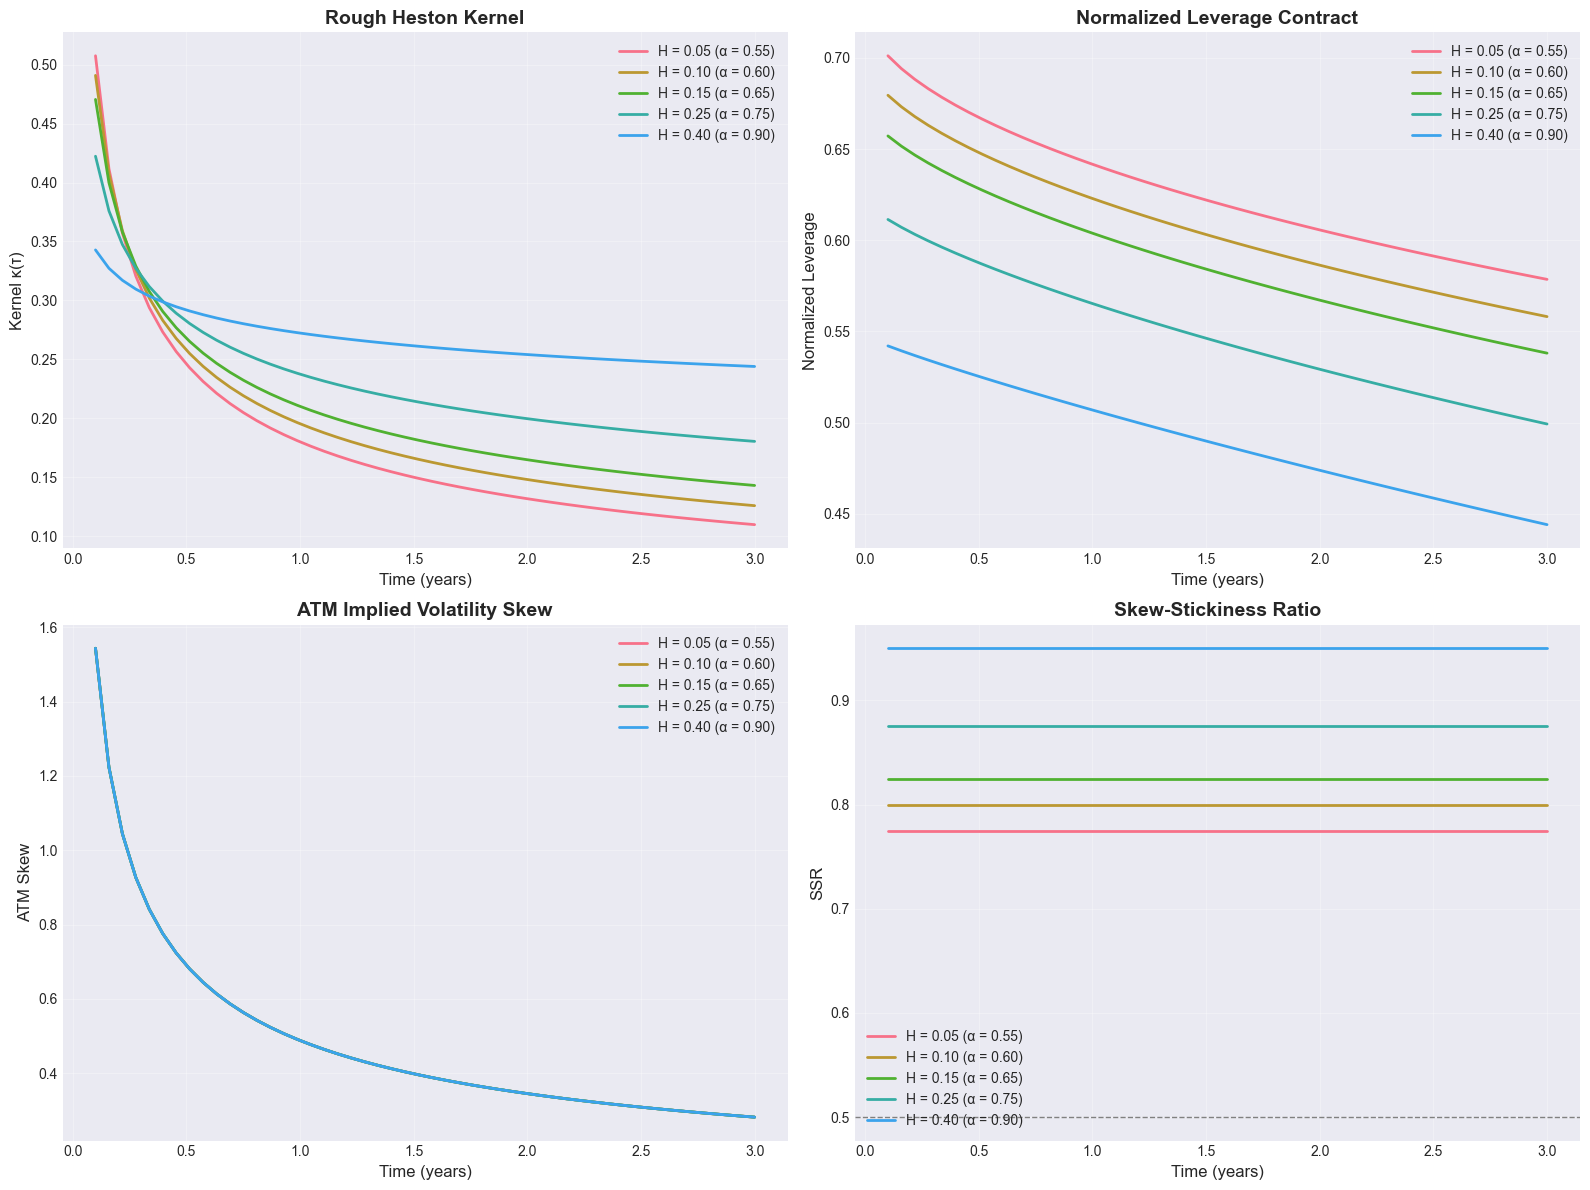


🔍 Observations:
   • Smaller H (rougher) → stronger memory effects
   • Kernel decays slower for rough H
   • ATM skew more pronounced for rough volatility
   • SSR increases with H (approaches sticky delta)


In [6]:
# Compare different Hurst parameters
H_values = [0.05, 0.10, 0.15, 0.25, 0.40]
expiries_compare = np.linspace(0.1, 3.0, 50)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for H in H_values:
    # Create params with this H
    params_h = RoughHestonParams(H, params.nu, params.rho, params.lambda_, params.theta, params.v0)
    char_func_h = RoughHestonCharFunc(params_h)
    
    # Calculate quantities
    kernels_h = [rough_heston_kernel(t, params_h) for t in expiries_compare]
    leverage_h = [normalized_leverage_contract(t, params_h) for t in expiries_compare]
    skews_h = [atm_skew(char_func_h, t) for t in expiries_compare]
    ssrs_h = [skew_stickiness_ratio(char_func_h, t) for t in expiries_compare]
    
    label = f'H = {H:.2f} (α = {H+0.5:.2f})'
    
    # Plot kernel
    axes[0, 0].plot(expiries_compare, kernels_h, linewidth=2, label=label)
    
    # Plot leverage
    axes[0, 1].plot(expiries_compare, leverage_h, linewidth=2, label=label)
    
    # Plot ATM skew
    axes[1, 0].plot(expiries_compare, skews_h, linewidth=2, label=label)
    
    # Plot SSR
    axes[1, 1].plot(expiries_compare, ssrs_h, linewidth=2, label=label)

# Configure subplots
axes[0, 0].set_xlabel('Time (years)', fontsize=12)
axes[0, 0].set_ylabel('Kernel κ(τ)', fontsize=12)
axes[0, 0].set_title('Rough Heston Kernel', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].set_xlabel('Time (years)', fontsize=12)
axes[0, 1].set_ylabel('Normalized Leverage', fontsize=12)
axes[0, 1].set_title('Normalized Leverage Contract', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].set_xlabel('Time (years)', fontsize=12)
axes[1, 0].set_ylabel('ATM Skew', fontsize=12)
axes[1, 0].set_title('ATM Implied Volatility Skew', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].set_xlabel('Time (years)', fontsize=12)
axes[1, 1].set_ylabel('SSR', fontsize=12)
axes[1, 1].set_title('Skew-Stickiness Ratio', fontsize=14, fontweight='bold')
axes[1, 1].axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🔍 Observations:")
print("   • Smaller H (rougher) → stronger memory effects")
print("   • Kernel decays slower for rough H")
print("   • ATM skew more pronounced for rough volatility")
print("   • SSR increases with H (approaches sticky delta)")

## 6. Summary and Key Takeaways

### What We Learned

1. **Mittag-Leffler functions** generalize exponentials for fractional calculus
   - Power-law decay vs exponential decay
   - Essential for rough volatility modeling

2. **Rough Heston kernel** combines:
   - Power-law memory (τ^(α-1) term)
   - Mean reversion (Mittag-Leffler exponential damping)

3. **Leverage swaps** quantify correlation between returns and volatility
   - Negative leverage effect in equity markets
   - Path-dependent but model-free

4. **ATM skew** follows 1/√τ term structure
   - Steeper for short-dated options
   - Directly linked to correlation ρ

5. **SSR** indicates smile stickiness regime
   - Rough Heston typically gives SSR ≈ 0.6-0.7 (between sticky-moneyness and sticky-delta)

### Why Rough Volatility Matters

- **Empirical fit:** Better matches market implied volatility surfaces
- **Realistic dynamics:** Captures observed roughness in realized volatility
- **Arbitrage-free:** Affine structure ensures tractability
- **Calibration:** Fewer parameters than local/stochastic vol models

### References

**Bourgey, F. (2024).** *Rough Volatility Workshop - QM2024_3_Affine_models*.  
GitHub: [https://github.com/fbourgey/RoughVolatilityWorkshop](https://github.com/fbourgey/RoughVolatilityWorkshop/blob/main/QM2024_3_Affine_models.ipynb)

---

**Next Steps:**
- Explore full characteristic function via Riccati equations
- Implement FFT pricing for European options
- Calibrate to market implied volatility surfaces
- Compare with classical Heston model